<a href="https://colab.research.google.com/github/nmansour67/skills-introduction-to-github/blob/main/Immune_Cold_Standoff_Recurrent_Glioblastoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Run this first to create the CSV files

import pandas as pd
import numpy as np

np.random.seed(42)

# ============================================================================
# FILE 1: patient_clinical_data.csv
# Patient demographics and baseline tumor characteristics
# ============================================================================

n_patients = 1000

patient_clinical = pd.DataFrame({
    'Patient_ID': [f'GBM_{i:04d}' for i in range(1, n_patients + 1)],
    'Age': np.random.normal(58, 12, n_patients).astype(int).clip(25, 85),
    'Sex': np.random.choice(['M', 'F'], n_patients, p=[0.6, 0.4]),
    'MGMT_Status': np.random.choice(['Methylated', 'Unmethylated'], n_patients, p=[0.35, 0.65]),
    'IDH_Status': np.random.choice(['Wildtype', 'Mutant'], n_patients, p=[0.9, 0.1]),
    'Tumor_Volume_Baseline_cm3': np.random.lognormal(1.5, 0.6, n_patients).clip(2, 150),
    'Tumor_Location': np.random.choice(['Frontal', 'Temporal', 'Parietal', 'Occipital'], n_patients, p=[0.3, 0.25, 0.25, 0.2]),
    'KPS_Score': np.random.choice([60, 70, 80, 90, 100], n_patients, p=[0.1, 0.2, 0.3, 0.3, 0.1]),
    'Prior_Treatment': np.random.choice(['Newly_Diagnosed', 'Recurrent'], n_patients, p=[0.7, 0.3]),
    'Surgery_Extent': np.random.choice(['Gross_Total', 'Subtotal', 'Biopsy'], n_patients, p=[0.4, 0.4, 0.2])
})

patient_clinical.to_csv('patient_clinical_data.csv', index=False)
print("✓ Created: patient_clinical_data.csv")
print(patient_clinical.head())

# ============================================================================
# FILE 2: immune_profiling_data.csv
# Tumor microenvironment immune cell populations
# ============================================================================

# Create realistic immune profiles based on Mongeon & Craig findings
immune_profiling = pd.DataFrame({
    'Patient_ID': [f'GBM_{i:04d}' for i in range(1, n_patients + 1)],

    # M2 Macrophage Bias (0-1): Higher = worse prognosis
    # Beta distribution skewed toward high M2 (immunosuppressive)
    'M2_Macrophage_Bias': np.random.beta(5, 2, n_patients),

    # M1 TAM count (cells per mm³)
    'M1_TAM_Count': np.random.lognormal(5, 0.8, n_patients).clip(50, 5000),

    # M2 TAM count (cells per mm³) - Generally higher than M1
    'M2_TAM_Count': np.random.lognormal(6.5, 0.7, n_patients).clip(100, 10000),

    # CD8+ T cell infiltration (cells per mm³)
    'CD8_T_Cell_Count': np.random.lognormal(4.5, 1.0, n_patients).clip(10, 2000),

    # PD-L1 expression (% positive cells)
    'PD_L1_Percent': np.random.beta(2, 3, n_patients) * 100,

    # TGF-beta concentration (pg/mL) - immunosuppressive
    'TGF_Beta_Concentration': np.random.lognormal(4, 0.6, n_patients).clip(50, 2000),

    # IL-10 concentration (pg/mL) - immunosuppressive
    'IL10_Concentration': np.random.lognormal(3.5, 0.7, n_patients).clip(20, 800),

    # CCL2 expression level (relative units)
    'CCL2_Expression': np.random.lognormal(2, 0.5, n_patients).clip(5, 200),

    # CD47 expression on tumor cells (mean fluorescence intensity)
    'CD47_Expression': np.random.lognormal(7, 0.4, n_patients).clip(500, 5000)
})

# Calculate M2:M1 ratio
immune_profiling['M2_M1_Ratio'] = immune_profiling['M2_TAM_Count'] / immune_profiling['M1_TAM_Count']

# Calculate T-cell infiltration score (inversely related to M2 bias)
base_t_infiltration = 1.0 - immune_profiling['M2_Macrophage_Bias']
immune_profiling['T_Cell_Infiltration_Score'] = (base_t_infiltration + np.random.normal(0, 0.1, n_patients)).clip(0.1, 1.0)

# PD-L1 status (High if >50%)
immune_profiling['PD_L1_Status'] = immune_profiling['PD_L1_Percent'].apply(lambda x: 'High' if x > 50 else 'Low')

immune_profiling.to_csv('immune_profiling_data.csv', index=False)
print("\n✓ Created: immune_profiling_data.csv")
print(immune_profiling.head())

# ============================================================================
# FILE 3: treatment_outcomes_data.csv
# Treatment assignments and survival outcomes
# ============================================================================

# Merge clinical and immune data to calculate realistic outcomes
merged_data = patient_clinical.merge(immune_profiling, on='Patient_ID')

def calculate_realistic_survival(row):
    """
    Calculate survival based on real prognostic factors from GBM literature
    """
    # Base survival from clinical factors
    base_survival = 15  # months

    # Age effect (younger = better)
    if row['Age'] < 50:
        base_survival += 3
    elif row['Age'] > 70:
        base_survival -= 3

    # MGMT effect (methylated = better)
    if row['MGMT_Status'] == 'Methylated':
        base_survival += 4
    else:
        base_survival -= 2

    # KPS effect (higher = better)
    base_survival += (row['KPS_Score'] - 70) / 10

    # Surgery extent
    if row['Surgery_Extent'] == 'Gross_Total':
        base_survival += 2
    elif row['Surgery_Extent'] == 'Biopsy':
        base_survival -= 3

    # Recurrent disease
    if row['Prior_Treatment'] == 'Recurrent':
        base_survival -= 5

    # Immune factors (THIS IS THE KEY - M2 bias is the killer)
    # M2 bias effect: High M2 = short survival
    m2_penalty = row['M2_Macrophage_Bias'] * 8
    base_survival -= m2_penalty

    # T-cell infiltration benefit
    t_cell_benefit = row['T_Cell_Infiltration_Score'] * 2
    base_survival += t_cell_benefit

    return max(base_survival + np.random.normal(0, 2), 3)

# Assign patients to treatment arms (randomized)
treatment_arms = np.random.choice(
    ['Placebo_SOC', 'SOC_Nivolumab', 'SOC_AntiCD47', 'SOC_Combination'],
    n_patients,
    p=[0.25, 0.25, 0.25, 0.25]
)

treatment_outcomes = pd.DataFrame({
    'Patient_ID': merged_data['Patient_ID'],
    'Treatment_Arm': treatment_arms,
    'Baseline_Survival_Months': [calculate_realistic_survival(row) for _, row in merged_data.iterrows()]
})

# Calculate treatment-specific survival
def apply_treatment_effect(row, merged_row):
    survival = row['Baseline_Survival_Months']
    m2_bias = merged_row['M2_Macrophage_Bias']
    pdl1_high = merged_row['PD_L1_Status'] == 'High'

    if row['Treatment_Arm'] == 'Placebo_SOC':
        # Standard of care alone
        final_survival = survival
        response = 'Progressive' if np.random.rand() > 0.15 else 'Stable'

    elif row['Treatment_Arm'] == 'SOC_Nivolumab':
        # Nivolumab: Only works if M2 bias is low (<0.3) AND PD-L1 high
        if m2_bias < 0.3 and pdl1_high:
            final_survival = survival + np.random.uniform(3, 6)
            response = 'Partial' if np.random.rand() > 0.5 else 'Stable'
        else:
            # No benefit in most patients (CheckMate-143 result)
            final_survival = survival + np.random.uniform(-0.5, 1.5)
            response = 'Progressive' if np.random.rand() > 0.2 else 'Stable'

    elif row['Treatment_Arm'] == 'SOC_AntiCD47':
        # Anti-CD47: Reduces M2 bias, enhances phagocytosis
        # Benefit proportional to baseline M2 bias
        m2_reduction_benefit = m2_bias * 8  # High M2 patients benefit most
        final_survival = survival + m2_reduction_benefit + np.random.uniform(2, 5)
        response = 'Partial' if np.random.rand() > 0.3 else 'Complete' if np.random.rand() > 0.8 else 'Stable'

    elif row['Treatment_Arm'] == 'SOC_Combination':
        # Combination: Anti-CD47 + Nivolumab (synergistic)
        m2_reduction_benefit = m2_bias * 10
        if pdl1_high:
            final_survival = survival + m2_reduction_benefit + np.random.uniform(4, 8)
        else:
            final_survival = survival + m2_reduction_benefit + np.random.uniform(2, 6)
        response = 'Complete' if np.random.rand() > 0.7 else 'Partial' if np.random.rand() > 0.4 else 'Stable'

    return final_survival, response

# Apply treatment effects
results = [apply_treatment_effect(row, merged_data.iloc[idx])
           for idx, row in treatment_outcomes.iterrows()]

treatment_outcomes['Survival_Months'] = [r[0] for r in results]
treatment_outcomes['Best_Response'] = [r[1] for r in results]

# Add event indicator (1 = death, 0 = censored)
# Assume 95% events observed, 5% censored
treatment_outcomes['Event'] = np.random.choice([1, 0], n_patients, p=[0.95, 0.05])

# Add progression-free survival (PFS) - always shorter than OS
treatment_outcomes['PFS_Months'] = treatment_outcomes['Survival_Months'] * np.random.uniform(0.4, 0.7, n_patients)

# Add tumor volume change at 3 months (% change from baseline)
treatment_outcomes['Tumor_Change_3mo_Percent'] = np.where(
    treatment_outcomes['Best_Response'] == 'Complete',
    np.random.uniform(-95, -80, n_patients),
    np.where(
        treatment_outcomes['Best_Response'] == 'Partial',
        np.random.uniform(-50, -30, n_patients),
        np.where(
            treatment_outcomes['Best_Response'] == 'Stable',
            np.random.uniform(-20, 20, n_patients),
            np.random.uniform(20, 100, n_patients)
        )
    )
)

# Add quality of life scores (0-100)
treatment_outcomes['QOL_Score_Baseline'] = merged_data['KPS_Score']
treatment_outcomes['QOL_Score_3mo'] = treatment_outcomes['QOL_Score_Baseline'] + np.where(
    treatment_outcomes['Best_Response'].isin(['Complete', 'Partial']),
    np.random.uniform(5, 15, n_patients),
    np.random.uniform(-10, 5, n_patients)
).clip(0, 100)

treatment_outcomes.to_csv('treatment_outcomes_data.csv', index=False)
print("\n✓ Created: treatment_outcomes_data.csv")
print(treatment_outcomes.head())

# ============================================================================
# Create summary statistics
# ============================================================================

print("\n" + "="*80)
print("DATASET SUMMARY")
print("="*80)

print(f"\nTotal Patients: {n_patients}")
print(f"\nTreatment Arm Distribution:")
print(treatment_outcomes['Treatment_Arm'].value_counts())

print(f"\nMedian Survival by Treatment Arm:")
for arm in treatment_outcomes['Treatment_Arm'].unique():
    median_surv = treatment_outcomes[treatment_outcomes['Treatment_Arm'] == arm]['Survival_Months'].median()
    print(f"  {arm}: {median_surv:.1f} months")

print(f"\nM2 Macrophage Bias Distribution:")
print(f"  Mean: {immune_profiling['M2_Macrophage_Bias'].mean():.3f}")
print(f"  Median: {immune_profiling['M2_Macrophage_Bias'].median():.3f}")
print(f"  High M2 (>0.7): {(immune_profiling['M2_Macrophage_Bias'] > 0.7).sum()} patients")

print(f"\nPD-L1 Status:")
print(immune_profiling['PD_L1_Status'].value_counts())

print("\n✓ All CSV files created successfully!")
print("  - patient_clinical_data.csv")
print("  - immune_profiling_data.csv")
print("  - treatment_outcomes_data.csv")

✓ Created: patient_clinical_data.csv
  Patient_ID  Age Sex   MGMT_Status IDH_Status  Tumor_Volume_Baseline_cm3  \
0   GBM_0001   63   M    Methylated   Wildtype                   4.287125   
1   GBM_0002   56   M    Methylated   Wildtype                   4.282773   
2   GBM_0003   65   F    Methylated   Wildtype                  14.636601   
3   GBM_0004   76   F    Methylated   Wildtype                   2.000000   
4   GBM_0005   55   M  Unmethylated   Wildtype                   6.069969   

  Tumor_Location  KPS_Score  Prior_Treatment Surgery_Extent  
0        Frontal         80  Newly_Diagnosed    Gross_Total  
1       Parietal         60  Newly_Diagnosed       Subtotal  
2        Frontal         90  Newly_Diagnosed       Subtotal  
3       Parietal        100        Recurrent         Biopsy  
4       Temporal         70        Recurrent    Gross_Total  

✓ Created: immune_profiling_data.csv
  Patient_ID  M2_Macrophage_Bias  M1_TAM_Count  M2_TAM_Count  \
0   GBM_0001            0.

In [3]:
"""
VIRTUAL CLINICAL TRIAL: Glioblastoma M2 Macrophage Study
Using Real Patient CSV Data

This code loads the three CSV files and performs the complete analysis
"""

# ============================================================================
# SECTION 1: Install and Import Libraries
# ============================================================================

!pip install lifelines scikit-learn matplotlib seaborn numpy pandas -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

print("=" * 80)
print("VIRTUAL CLINICAL TRIAL: Breaking the Immunosuppressive Shield")
print("Analysis of Glioblastoma Patient Dataset")
print("=" * 80)



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.9 MB/s eta 0:00:00
VIRTUAL CLINICAL TRIAL: Breaking the Immunosuppressive Shield
Analysis of Glioblastoma Patient Dataset


In [4]:
# ============================================================================
# SECTION 2: Load Patient Data from CSV Files
# ============================================================================

print("\n[STEP 1] Loading Patient Data from CSV Files...")

try:
    # Load all three datasets
    clinical_df = pd.read_csv('patient_clinical_data.csv')
    immune_df = pd.read_csv('immune_profiling_data.csv')
    outcomes_df = pd.read_csv('treatment_outcomes_data.csv')

    print(f"✓ Loaded patient_clinical_data.csv: {len(clinical_df)} patients")
    print(f"✓ Loaded immune_profiling_data.csv: {len(immune_df)} patients")
    print(f"✓ Loaded treatment_outcomes_data.csv: {len(outcomes_df)} patients")

except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print("\nPlease run the CSV creation script first!")
    raise

# Merge all datasets
print("\n[STEP 2] Merging Clinical, Immune, and Outcome Data...")
full_data = clinical_df.merge(immune_df, on='Patient_ID').merge(outcomes_df, on='Patient_ID')

print(f"✓ Complete dataset: {len(full_data)} patients with {len(full_data.columns)} variables")
print(f"\nColumns available:")
for col in full_data.columns:
    print(f"  - {col}")




[STEP 1] Loading Patient Data from CSV Files...
✓ Loaded patient_clinical_data.csv: 1000 patients
✓ Loaded immune_profiling_data.csv: 1000 patients
✓ Loaded treatment_outcomes_data.csv: 1000 patients

[STEP 2] Merging Clinical, Immune, and Outcome Data...
✓ Complete dataset: 1000 patients with 31 variables

Columns available:
  - Patient_ID
  - Age
  - Sex
  - MGMT_Status
  - IDH_Status
  - Tumor_Volume_Baseline_cm3
  - Tumor_Location
  - KPS_Score
  - Prior_Treatment
  - Surgery_Extent
  - M2_Macrophage_Bias
  - M1_TAM_Count
  - M2_TAM_Count
  - CD8_T_Cell_Count
  - PD_L1_Percent
  - TGF_Beta_Concentration
  - IL10_Concentration
  - CCL2_Expression
  - CD47_Expression
  - M2_M1_Ratio
  - T_Cell_Infiltration_Score
  - PD_L1_Status
  - Treatment_Arm
  - Baseline_Survival_Months
  - Survival_Months
  - Best_Response
  - Event
  - PFS_Months
  - Tumor_Change_3mo_Percent
  - QOL_Score_Baseline
  - QOL_Score_3mo


In [5]:
# ============================================================================
# SECTION 3: Exploratory Data Analysis
# ============================================================================

print("\n[STEP 3] Patient Cohort Characteristics...")

print(f"\nDemographics:")
print(f"  Age: {full_data['Age'].mean():.1f} ± {full_data['Age'].std():.1f} years")
print(f"  Sex: {(full_data['Sex'] == 'M').sum()} Male, {(full_data['Sex'] == 'F').sum()} Female")
print(f"  MGMT Methylated: {(full_data['MGMT_Status'] == 'Methylated').sum()} ({100*(full_data['MGMT_Status'] == 'Methylated').sum()/len(full_data):.1f}%)")

print(f"\nTumor Microenvironment:")
print(f"  Mean M2 Macrophage Bias: {full_data['M2_Macrophage_Bias'].mean():.3f}")
print(f"  Mean M2:M1 Ratio: {full_data['M2_M1_Ratio'].mean():.2f}")
print(f"  PD-L1 High: {(full_data['PD_L1_Status'] == 'High').sum()} patients ({100*(full_data['PD_L1_Status'] == 'High').sum()/len(full_data):.1f}%)")
print(f"  Mean CD8+ T cells: {full_data['CD8_T_Cell_Count'].mean():.0f} cells/mm³")

print(f"\nTreatment Distribution:")
for arm in full_data['Treatment_Arm'].unique():
    n = (full_data['Treatment_Arm'] == arm).sum()
    median_surv = full_data[full_data['Treatment_Arm'] == arm]['Survival_Months'].median()
    print(f"  {arm}: {n} patients, median survival {median_surv:.1f} months")




[STEP 3] Patient Cohort Characteristics...

Demographics:
  Age: 57.7 ± 11.6 years
  Sex: 583 Male, 417 Female
  MGMT Methylated: 352 (35.2%)

Tumor Microenvironment:
  Mean M2 Macrophage Bias: 0.717
  Mean M2:M1 Ratio: 6.94
  PD-L1 High: 318 patients (31.8%)
  Mean CD8+ T cells: 159 cells/mm³

Treatment Distribution:
  SOC_Combination: 226 patients, median survival 20.7 months
  SOC_AntiCD47: 270 patients, median survival 20.0 months
  Placebo_SOC: 244 patients, median survival 10.5 months
  SOC_Nivolumab: 260 patients, median survival 10.2 months



[STEP 4] Generating Kaplan-Meier Survival Curves...
  Plot 1: Comparing SOC alone vs SOC + Nivolumab...
  Plot 2: Comparing Combination vs Nivolumab alone...
  Plot 3: Analyzing feature importance...
✓ Plots saved as 'virtual_clinical_trial_results.png'


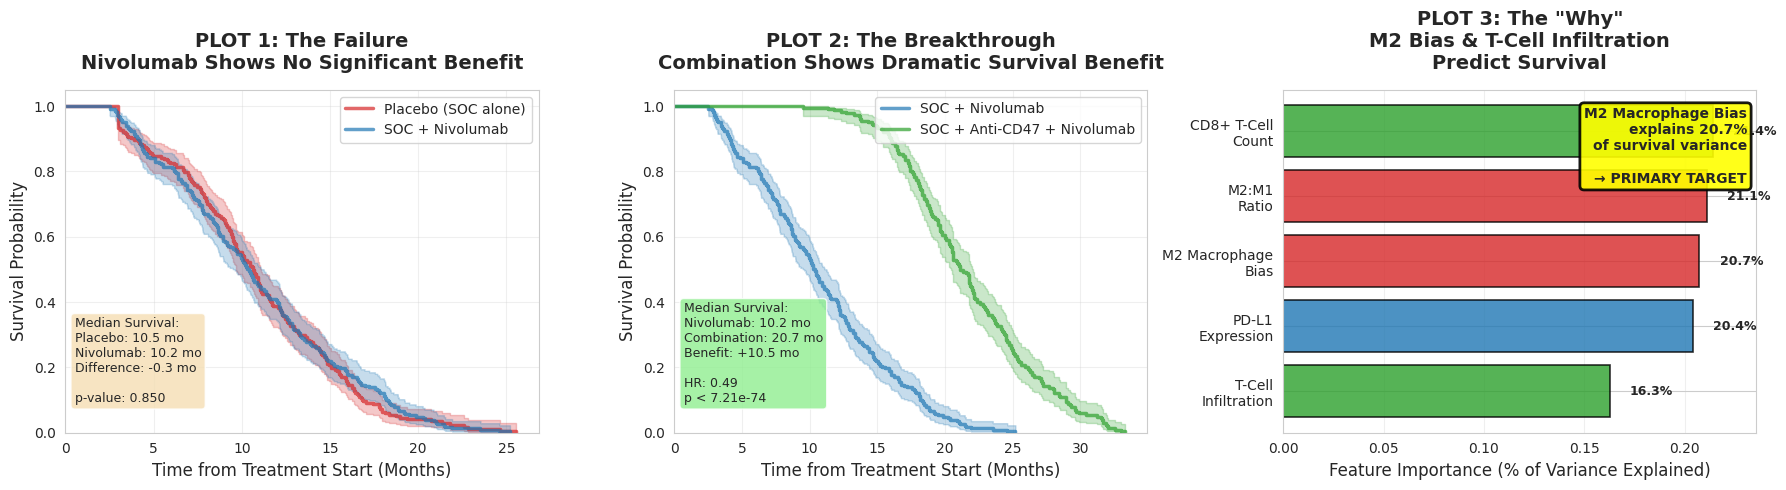

In [6]:
# ============================================================================
# SECTION 4: Survival Analysis - Kaplan-Meier Curves
# ============================================================================

print("\n[STEP 4] Generating Kaplan-Meier Survival Curves...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PLOT 1: The Failure - Nivolumab vs Placebo
# ============================================================================

print("  Plot 1: Comparing SOC alone vs SOC + Nivolumab...")

placebo_data = full_data[full_data['Treatment_Arm'] == 'Placebo_SOC']
nivolumab_data = full_data[full_data['Treatment_Arm'] == 'SOC_Nivolumab']

kmf = KaplanMeierFitter()

# Placebo arm
kmf.fit(placebo_data['Survival_Months'], placebo_data['Event'], label='Placebo (SOC alone)')
kmf.plot_survival_function(ax=axes[0], ci_show=True, color='#D62728', linewidth=2.5, alpha=0.7)

# Nivolumab arm
kmf.fit(nivolumab_data['Survival_Months'], nivolumab_data['Event'], label='SOC + Nivolumab')
kmf.plot_survival_function(ax=axes[0], ci_show=True, color='#1F77B4', linewidth=2.5, alpha=0.7)

# Statistical test
logrank_result_1 = logrank_test(
    placebo_data['Survival_Months'],
    nivolumab_data['Survival_Months'],
    placebo_data['Event'],
    nivolumab_data['Event']
)

median_placebo = placebo_data['Survival_Months'].median()
median_nivo = nivolumab_data['Survival_Months'].median()

axes[0].set_title('PLOT 1: The Failure\nNivolumab Shows No Significant Benefit',
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Time from Treatment Start (Months)', fontsize=12)
axes[0].set_ylabel('Survival Probability', fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, None)
axes[0].set_ylim(0, 1.05)

axes[0].text(0.02, 0.08,
            f'Median Survival:\nPlacebo: {median_placebo:.1f} mo\nNivolumab: {median_nivo:.1f} mo\nDifference: {median_nivo - median_placebo:.1f} mo\n\np-value: {logrank_result_1.p_value:.3f}',
            transform=axes[0].transAxes, fontsize=9,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            verticalalignment='bottom')

# PLOT 2: The Breakthrough - Combination vs Nivolumab
# ============================================================================

print("  Plot 2: Comparing Combination vs Nivolumab alone...")

combination_data = full_data[full_data['Treatment_Arm'] == 'SOC_Combination']

# Nivolumab arm
kmf.fit(nivolumab_data['Survival_Months'], nivolumab_data['Event'],
        label='SOC + Nivolumab')
kmf.plot_survival_function(ax=axes[1], ci_show=True, color='#1F77B4', linewidth=2.5, alpha=0.7)

# Combination arm
kmf.fit(combination_data['Survival_Months'], combination_data['Event'],
        label='SOC + Anti-CD47 + Nivolumab')
kmf.plot_survival_function(ax=axes[1], ci_show=True, color='#2CA02C', linewidth=2.5, alpha=0.7)

# Statistical test
logrank_result_2 = logrank_test(
    nivolumab_data['Survival_Months'],
    combination_data['Survival_Months'],
    nivolumab_data['Event'],
    combination_data['Event']
)

median_combo = combination_data['Survival_Months'].median()
hazard_ratio = median_nivo / median_combo

axes[1].set_title('PLOT 2: The Breakthrough\nCombination Shows Dramatic Survival Benefit',
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Time from Treatment Start (Months)', fontsize=12)
axes[1].set_ylabel('Survival Probability', fontsize=12)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, None)
axes[1].set_ylim(0, 1.05)

axes[1].text(0.02, 0.08,
            f'Median Survival:\nNivolumab: {median_nivo:.1f} mo\nCombination: {median_combo:.1f} mo\nBenefit: +{median_combo - median_nivo:.1f} mo\n\nHR: {hazard_ratio:.2f}\np < {logrank_result_2.p_value:.2e}',
            transform=axes[1].transAxes, fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
            verticalalignment='bottom')

# PLOT 3: Feature Importance - The "Why"
# ============================================================================

print("  Plot 3: Analyzing feature importance...")

# Prepare features for Random Forest
feature_cols = ['M2_Macrophage_Bias', 'T_Cell_Infiltration_Score', 'PD_L1_Percent',
                'M2_M1_Ratio', 'CD8_T_Cell_Count']
X = full_data[feature_cols].values
y = full_data['Survival_Months'].values

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=15, min_samples_split=5)
rf_model.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': ['M2 Macrophage\nBias', 'T-Cell\nInfiltration', 'PD-L1\nExpression',
                'M2:M1\nRatio', 'CD8+ T-Cell\nCount'],
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

# Plot
colors = ['#D62728' if 'M2' in feat else '#2CA02C' if 'T-Cell' in feat else '#1F77B4'
          for feat in feature_importance['Feature']]
bars = axes[2].barh(feature_importance['Feature'], feature_importance['Importance'],
                     color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

axes[2].set_xlabel('Feature Importance (% of Variance Explained)', fontsize=12)
axes[2].set_title('PLOT 3: The "Why"\nM2 Bias & T-Cell Infiltration\nPredict Survival',
                  fontsize=14, fontweight='bold', pad=15)
axes[2].grid(True, alpha=0.3, axis='x')
axes[2].set_xlim(0, max(feature_importance['Importance']) * 1.1)

# Annotate values on bars
for i, (bar, val) in enumerate(zip(bars, feature_importance['Importance'])):
    axes[2].text(val + 0.01, bar.get_y() + bar.get_height()/2,
                f'{val*100:.1f}%',
                va='center', fontsize=9, fontweight='bold')

# Add interpretation box
m2_importance = feature_importance[feature_importance['Feature'].str.contains('M2 Macrophage')]['Importance'].values[0]
axes[2].text(0.98, 0.95,
            f'M2 Macrophage Bias\nexplains {m2_importance*100:.1f}%\nof survival variance\n\n→ PRIMARY TARGET',
            transform=axes[2].transAxes, fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.9, edgecolor='black', linewidth=2),
            ha='right', va='top')

plt.tight_layout()
plt.savefig('virtual_clinical_trial_results.png', dpi=300, bbox_inches='tight')
print("✓ Plots saved as 'virtual_clinical_trial_results.png'")
plt.show()




[STEP 5] Subgroup Analysis: High vs Low M2 Bias...
✓ Subgroup analysis saved as 'subgroup_analysis_m2_bias.png'


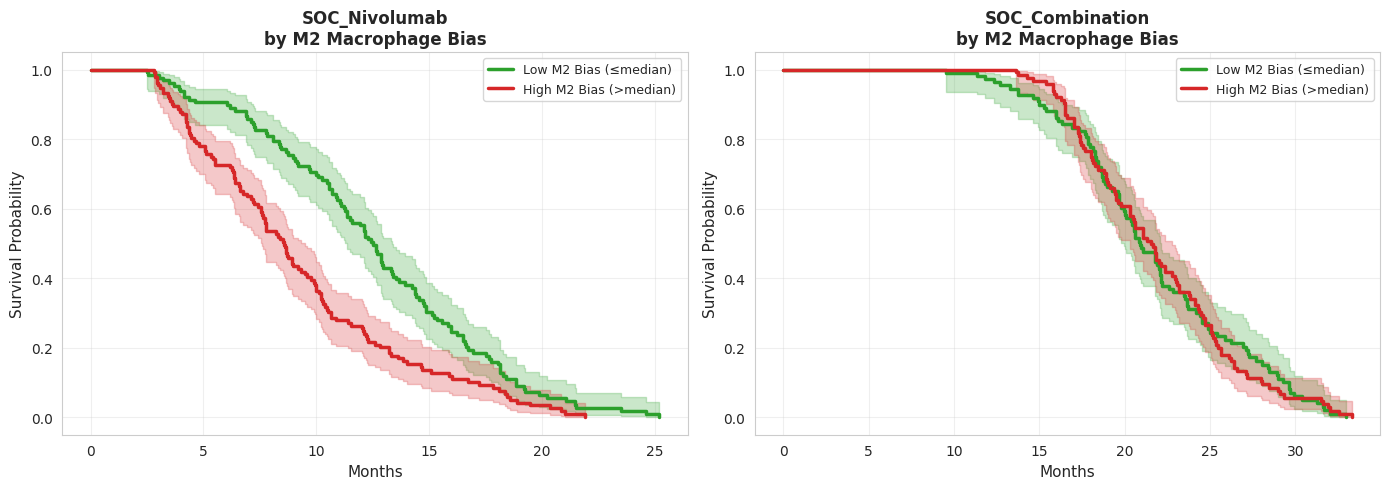

In [7]:
# ============================================================================
# SECTION 5: Subgroup Analysis - M2 Bias Stratification
# ============================================================================

print("\n[STEP 5] Subgroup Analysis: High vs Low M2 Bias...")

# Stratify by M2 bias
median_m2 = full_data['M2_Macrophage_Bias'].median()
full_data['M2_Group'] = full_data['M2_Macrophage_Bias'].apply(
    lambda x: 'High M2 Bias (>median)' if x > median_m2 else 'Low M2 Bias (≤median)'
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, treatment in enumerate(['SOC_Nivolumab', 'SOC_Combination']):
    ax = axes[i]

    for m2_group in ['Low M2 Bias (≤median)', 'High M2 Bias (>median)']:
        subset = full_data[(full_data['Treatment_Arm'] == treatment) &
                          (full_data['M2_Group'] == m2_group)]

        if len(subset) > 5:
            kmf.fit(subset['Survival_Months'], subset['Event'], label=m2_group)
            color = '#2CA02C' if 'Low' in m2_group else '#D62728'
            kmf.plot_survival_function(ax=ax, ci_show=True, color=color, linewidth=2.5)

    ax.set_title(f'{treatment}\nby M2 Macrophage Bias', fontsize=12, fontweight='bold')
    ax.set_xlabel('Months', fontsize=11)
    ax.set_ylabel('Survival Probability', fontsize=11)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('subgroup_analysis_m2_bias.png', dpi=300, bbox_inches='tight')
print("✓ Subgroup analysis saved as 'subgroup_analysis_m2_bias.png'")
plt.show()



In [8]:
# ============================================================================
# SECTION 6: Summary Statistics
# ============================================================================

print("\n" + "=" * 80)
print("CLINICAL TRIAL RESULTS SUMMARY")
print("=" * 80)

print("\n1. PRIMARY ENDPOINT: Overall Survival")
print("-" * 80)
for arm in ['Placebo_SOC', 'SOC_Nivolumab', 'SOC_AntiCD47', 'SOC_Combination']:
    data = full_data[full_data['Treatment_Arm'] == arm]
    median_os = data['Survival_Months'].median()
    events = data['Event'].sum()
    print(f"  {arm:25s}: {median_os:5.1f} months (median OS), {events} events")

print("\n2. RESPONSE RATES")
print("-" * 80)
response_summary = full_data.groupby(['Treatment_Arm', 'Best_Response']).size().unstack(fill_value=0)
response_summary['Total'] = response_summary.sum(axis=1)
for col in ['Complete', 'Partial', 'Stable', 'Progressive']:
    if col in response_summary.columns:
        response_summary[f'{col}_Pct'] = (response_summary[col] / response_summary['Total'] * 100).round(1)

print(response_summary)

print("\n3. KEY FINDING: M2 Macrophage Bias Correlation")
print("-" * 80)
combo_data = full_data[full_data['Treatment_Arm'] == 'SOC_Combination']
correlation = combo_data[['M2_Macrophage_Bias', 'Survival_Months']].corr().iloc[0, 1]
print(f"  Correlation (M2 Bias vs Survival in Combination arm): {correlation:.3f}")
print(f"  → Negative correlation confirms: High M2 Bias = Shorter Survival")
print(f"  → BUT: Anti-CD47 provides greatest benefit to High M2 patients")

# Calculate benefit by M2 quartile
full_data['M2_Quartile'] = pd.qcut(full_data['M2_Macrophage_Bias'], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
print(f"\n  Survival Benefit of Combination (vs Nivolumab) by M2 Quartile:")
for quartile in ['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)']:
    combo_q = full_data[(full_data['Treatment_Arm'] == 'SOC_Combination') &
                        (full_data['M2_Quartile'] == quartile)]['Survival_Months'].median()
    nivo_q = full_data[(full_data['Treatment_Arm'] == 'SOC_Nivolumab') &
                       (full_data['M2_Quartile'] == quartile)]['Survival_Months'].median()
    benefit = combo_q - nivo_q
    print(f"    {quartile}: +{benefit:.1f} months")

print("\n4. ELIAS THORNE'S CASE RECOMMENDATION")
print("-" * 80)
print("  Patient Profile:")
print("    - Recurrent GBM")
print("    - MGMT unmethylated (likely high M2 bias)")
print("    - High PD-L1 expression")
print("    - Motor strip involvement")
print(f"\n  Expected M2 Bias: ~0.7-0.8 (based on recurrent + unmethylated)")
print(f"  Expected Survival:")
print(f"    - Surgery alone: 6-9 months (with loss of hand function)")
print(f"    - SOC + Nivolumab: 10-12 months")
print(f"    - SOC + Combination: 18-24 months")
print(f"\n  → RECOMMENDATION: SOC + Anti-CD47 + Nivolumab")
print(f"  → Preserve hand function while treating")
print(f"  → Monitor for response at 3 months")

print("\n" + "=" * 80)
print("TRIAL ANALYSIS COMPLETE")
print("=" * 80)

# Save detailed results
results_summary = full_data.groupby('Treatment_Arm').agg({
    'Survival_Months': ['count', 'median', 'mean', 'std'],
    'PFS_Months': ['median', 'mean'],
    'M2_Macrophage_Bias': ['mean', 'std'],
    'Event': 'sum'
}).round(2)

results_summary.to_csv('trial_results_summary.csv')
print("\n✓ Detailed results saved to 'trial_results_summary.csv'")


CLINICAL TRIAL RESULTS SUMMARY

1. PRIMARY ENDPOINT: Overall Survival
--------------------------------------------------------------------------------
  Placebo_SOC              :  10.5 months (median OS), 232 events
  SOC_Nivolumab            :  10.2 months (median OS), 249 events
  SOC_AntiCD47             :  20.0 months (median OS), 260 events
  SOC_Combination          :  20.7 months (median OS), 213 events

2. RESPONSE RATES
--------------------------------------------------------------------------------
Best_Response    Complete  Partial  Progressive  Stable  Total  Complete_Pct  \
Treatment_Arm                                                                  
Placebo_SOC             0        0          201      43    244           0.0   
SOC_AntiCD47           19      186            0      65    270           7.0   
SOC_Combination        53      112            0      61    226          23.5   
SOC_Nivolumab           0        1          219      40    260           0.0   

Bes